# Search and load a SASfit plugin function with Python
by Gonzalo Rumi, with modifications by Ingo Breßler

## Look for a _plugin_ function

With the following code, you can search for a function and obtain information about its parameters

In [8]:
# Using Path in contemporary Python provides easy&safe helper functions
from pathlib import Path
sasfit_path = Path().resolve().parent.parent
print(sasfit_path)
# override here if libsasfit is found somewhere else
# sasfit_path = Path(r"Y:\shared\SASfit-0.94.12-windows64")
assert sasfit_path.is_dir(), "Directory 'sasfit_path' not found!"

C:\Users\kohlbrecher\switchdrive


In [10]:
#
# This code gets all information about all the functions available as dll files
#

import os

# we get a list of the .dll files in the plugin folder
plugin_list = [
    fn.stem[10:]
    for fn in (sasfit_path / "SASfitGit/plugins").iterdir()
    if fn.name.startswith("libsasfit_") and fn.suffix == ".dll"
]
#plugin_list

In [12]:
from pprint import pprint

# we extract information about the functions stored in each of the header files
functions = {}
debug = False
for plugin in plugin_list: # please use variables names telling something about their purpose
    filename = sasfit_path / "SASfitGit/plugins" / f"sasfit_{plugin}.h"
    if debug:
        print(filename)
    with open(filename) as fh: # always use 'with' scope, handles file closing on exceptions for you
        try:
            for x in fh.read().split("/* ################ start ")[1:]:
                ftype = x[:2]
                name = (x[3:].split(" ################ */"))[0]
                description = (x.split("* \\brief")[1]).split(
                    "<more detailed documentation, see 'doxygen' docs>"
                )[0].splitlines()
                # filter out leading ' *' C-style comments from 2nd line on
                description = "".join([description[0]]
                                        +[line.strip().removeprefix("*")
                                          for line in description[2:]]).strip()
                #print(f"{ftype=}, {name=}, {description=}")

                parameters_section = x.split("\\par Required parameters:")[1].split("</table>")[0]
                #print(1,f"{parameters_section=}")
                # extract parameter name and description
                parameters = [par_field.split("</td>")[0].removeprefix(r"\b").strip()
                              for par_field in parameters_section.split("<td>")][1:]
                # group parameters to (name, description) tuples
                parameters = list(zip(*(iter(parameters),)*2))
                functions[name] = {
                    "name": name,
                    "type": ftype,
                    "description": description,
                    "parameters": parameters,
                    "group": plugin, # this should be 'plugin' instead of 'group', right?
                                     # perhaps, confused with SF plugin groups defined in .def files
                }
                if debug:
                    pprint(functions[name])
                    print()
        except:
            raise
            print("\n")  # Error retrieving parameters for "+i+"\n\n")


In [13]:
search = input(" * * * * * * *\nSearch for a particular function:")
print("\n * * * * * * *\n")

for func in functions: # please use variables names telling something about their purpose
    if search in func:
        print(func + "\n")
        print(functions[func]["description"])
        print("\nParameters:\n")
        for p in functions[func]["parameters"]:
            print(":\t".join(p))
        print("\n * * * * * * *\n")


 * * * * * * *



## Obtain the values for a function by means of the _.dll_ file

You can copy the name and group of the function you looked for above and obtain useful values for your code.

### Required imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
from ctypes import *
import sys
import os

In [15]:
# Using Path in contemporary Python provides easy&safe helper functions
from pathlib import Path
sasfit_path = Path().resolve().parent.parent
# override here if libsasfit is found somewhere else
# sasfit_path = Path(r"Y:\shared\SASfit-0.94.12-windows64")
assert sasfit_path.is_dir(), "Directory 'sasfit_path' not found!"

## Load main SASfit DLL and init the Plugin

### Need to define the SASfit parameter structure first
Needed to get error messages and such ...

In [16]:
# has to match the value in
# https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_constants.h#L45
MAXPAR = 50
STRLEN = 256 # defined below MAXPAR in the same file

# defining an equivalent of the C sasfit_param struct
# https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_function.h#L146
# according to https://docs.python.org/3/library/ctypes.html#structures-and-unions
class SASFIT_PARAM(ctypes.Structure):
    _fields_ = [("p", ctypes.c_double * MAXPAR),
                # sasfit_kernel_type, numbered sequentially, in:
                # https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_function.h#L118
                ("kernelSelector", ctypes.c_int),
                ("kernelSubSelector", ctypes.c_int),
                ("errStr", ctypes.c_char * STRLEN),
                ("errLen", ctypes.c_int),
                ("errStatus", ctypes.c_int),
                ("xarr", ctypes.c_void_p),
                ("yarr", ctypes.c_void_p),
                ("moreparam", ctypes.c_void_p),
                ("more_p", ctypes.c_double * MAXPAR),
                # function pointer, set to void* for now, not sure where this is used
                ("function", ctypes.c_void_p)
               ]

### Rebuilding SASfit data structures at play
Required for plugin management functions, such as setting the *stub* pointer (points to a table of internal SASfit functions, also some frequently used numerical algos). *SASfit does this for each plugin it loads.*

In [17]:
## Python implementation of *examples/example_sasfit_ff_fuzzysphere.c*
SASFIT_FUNC_ONE_T = CFUNCTYPE(c_double, c_double, POINTER(SASFIT_PARAM))
SASFIT_FUNC_VOL_T = CFUNCTYPE(c_double, c_double, POINTER(SASFIT_PARAM), c_int)
class SASFIT_PLUGIN_FUNC_T(ctypes.Structure):
    _fields_ = [("len", ctypes.c_int),
                ("name", ctypes.c_char_p),
                ("func", POINTER(SASFIT_FUNC_ONE_T)),
                ("func_f", POINTER(SASFIT_FUNC_ONE_T)),
                ("func_v", POINTER(SASFIT_FUNC_VOL_T)),]
class SASFIT_PLUGIN_INFO_T(ctypes.Structure):
    _fields_ = [("num", ctypes.c_int),
                ("functions", POINTER(SASFIT_PLUGIN_FUNC_T))]
class SASFIT_COMMON_STUBS_T(ctypes.Structure):
    _fields_ = [("func", ctypes.c_void_p*155),
                ]

### Mind the stubs!
It is important to call each plugins `do_init()` function first. Most importantly, it sets the *stubs* pointer which gives access to SASfits internal functions, such as `sasfit_param_set_err()` (called by `CHECK_COND*()`) and many numerical routines. They do not appear as DLL dependencies. The stub pointer is set pointing to a sasfit.dll structure during plugin loading which has to be replicated with python.

In [18]:
sasfit_path = Path("C:\\Users\\kohlbrecher\\switchdrive\\SASfitGit")
assert sasfit_path.is_dir(), "Directory 'sasfit_path' not found!"
os.chdir(sasfit_path) # needs to load dependent libs in main dir
print(sasfit_path)
SASFIT_CORE_DLL = cdll.LoadLibrary(str(sasfit_path / "libsasfit.dll"))
SASFIT_PLUGIN_DLL = cdll.LoadLibrary(str(sasfit_path / "plugins/libsasfit_t_r_y.dll" ))

C:\Users\kohlbrecher\switchdrive\SASfitGit


In [19]:
print("Initializing plugin ...")
pi = (POINTER(SASFIT_PLUGIN_INFO_T)*1)()
bool(pi) # a test
SASFIT_CORE_DLL.sasfit_common_stubs_ptr.restype = POINTER(SASFIT_COMMON_STUBS_T)
SASFIT_PLUGIN_DLL.do_init.restype = ctypes.c_int
if bool(SASFIT_PLUGIN_DLL.do_init(byref(pi),
                                SASFIT_CORE_DLL.sasfit_common_stubs_ptr(),
                                SASFIT_CORE_DLL.sasfit_plugin_search)):
    print("success.")
else:
    print("There is a problem!")

Initializing plugin ...
success.


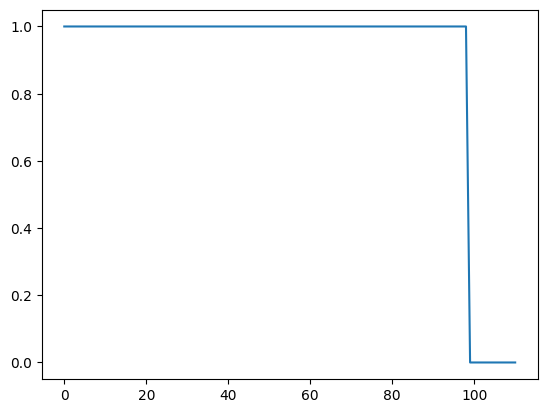

In [ ]:
def read_dll(xvec, *args):
    #read_gaussian = cdll.LoadLibrary(str(sasfit_path / "plugins" / "libsasfit_peak.dll")).sasfit_peak_gaussian_amplitude
    read_fgld_profile = SASFIT_PLUGIN_DLL.sasfit_ff_fgld_profile
#    read_gpolymer= cdll.LoadLibrary("C:\SASfit-0.94.12\plugins\libsasfit_polymer_chains.dll").sasfit_ff_gauspoly
#    read_HS=cdll.LoadLibrary("C:\SASfit-0.94.12\plugins\libsasfit_hard_spheres.dll").sasfit_sq_hard_sphere__4_3_
    
    read_fgld_profile.restype = c_double
    
    par = SASFIT_PARAM((args[:3]+(0, 0)+args[3:]))
    #par.p[2] *= -1 # SASFIT_CHECK_COND1() raising an error here
    par.p[0] = 1
    par.p[1] = 0
    par.p[2] = 98.1446
    par.p[3] = 1
    par.p[4] = 5.70225
    par.p[5] = -85.711
    par.p[6] = 16.731
    par.p[7] = -4.829
    par.p[8] = 10.1836
    par.p[9] = 1
    # list comprehensions are faster typically
    result = [read_fgld_profile(c_double(x), byref(par)) for x in xvec]
    assert not par.errStatus, par.errStr.decode("utf8")
    return result

xvec = np.arange(0, 111, 1)
plt.ion()
plt.plot(xvec, read_dll(xvec, 1, 4, 2.2, 0.2))
plt.show()

In [30]:
import ctypes
from ctypes import *
import sys
import os

sasfit_ff_fgld_profile=SASFIT_PLUGIN_DLL.sasfit_ff_fgld_profile

par=(ctypes.c_double * 10)(*[1, 0, 1446, 1, 5.70225, -85.711, 16.731, -4.829, 10.1836, 1])

sasfit_ff_fgld_profile.restype = c_double

sasfit_ff_fgld_profile(c_double(112), POINTER(c_double)(par))

1.0